## UPI Demand Forecasting: A Machine Learning Approach

In [1]:
# Importing the neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from statsmodels.regression.linear_model import OLS
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1 : Data Loading & Initial Observations

In [2]:
df = pd.read_excel(r"D:\9. Self Projects\4. Econometrics Project\Regression Model Data\UPI Demand Prediction data.xlsx")
df.head(2)

,Month,UPI_Value (Cr),GDP_Growth (%),CPI_Inflation (%),Smartphone_Penetration (%),Internet_Users (Mn),PMJDY_Accounts (Mn),POS_Terminals (Mn),Repo_Rate (%),Broadband_Users (Mn),COVID
0,2018-01,470420.1627,7.245071,4.191506,34.788777,417.546119,300.610781,3.117450,4.40,212.276489,0
1,2018-02,485975.2773,6.292604,4.498243,34.490947,416.679506,297.752688,3.208825,5.15,216.039718,0


In [ ]:
df.shape     # The rows are less as monthly data from 2018 to 2024

In [ ]:
df.dtypes    # Data types seems fine

In [ ]:
df.isnull().sum()             # As there is no null values, imputation is not needed.

In [ ]:
df.duplicated().sum()         # Also there is no duplicate data

###### ~ For now there is no need of Data Pre-processing step

### Step 2 : Exploratory Data Analysis (EDA)

In [3]:
df.describe()     # Univariate Analysis

,UPI_Value (Cr),GDP_Growth (%),CPI_Inflation (%),Smartphone_Penetration (%),Internet_Users (Mn),PMJDY_Accounts (Mn),POS_Terminals (Mn),Repo_Rate (%),Broadband_Users (Mn),COVID
count,8.400000e+01,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,1.554552e+06,6.339361,5.026657,50.009274,595.669310,397.920111,4.902612,5.548810,315.485923,0.190476
std,6.510475e+05,1.422683,0.936530,9.073759,103.210022,63.996200,1.012065,0.867692,61.816333,0.395035
min,4.704202e+05,2.570382,3.081229,34.490947,416.679506,287.583873,3.117450,4.000000,212.276489,0.000000
25%,9.643029e+05,5.581160,4.294872,42.313362,500.325041,344.294785,4.027888,5.150000,263.174078,0.000000
50%,1.568258e+06,6.309566,5.098364,50.021285,606.820275,399.186912,4.908145,5.700000,312.562282,0.000000
75%,2.121446e+06,7.262263,5.538170,57.692841,684.642560,454.178883,5.746907,6.250000,366.202481,0.000000
max,2.701405e+06,9.000000,7.463242,65.709769,779.178619,507.285237,6.676966,6.500000,421.544431,1.000000


##### - Here 'Internet_Users' and 'Broadband_Users' column may have outliers as there is a bit difference betwwen mean and median. Also 'CPI_Inflation' and 'Repo_Rate' have a very low Standard Deviation value, so I can drop it. But keeping 'Covid', cause it can directly affect UPI usage.

In [4]:
# Dropping the Redundant Features
df = df.drop(columns=['CPI_Inflation (%)', 'Repo_Rate (%)'])

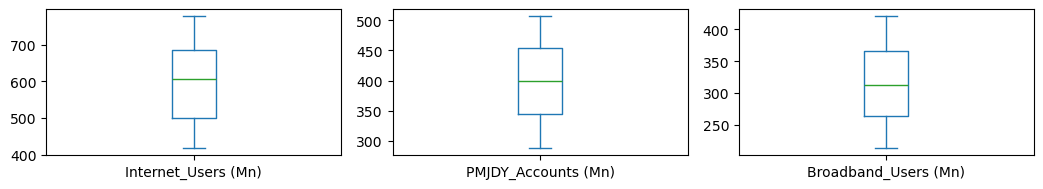

In [5]:
# Checking for outliers using Boxplot
df[["Internet_Users (Mn)", "PMJDY_Accounts (Mn)", "Broadband_Users (Mn)"]].plot( kind='box', figsize=(14, 2),
    subplots=True, layout=(1, 4))

plt.tight_layout()
plt.show()

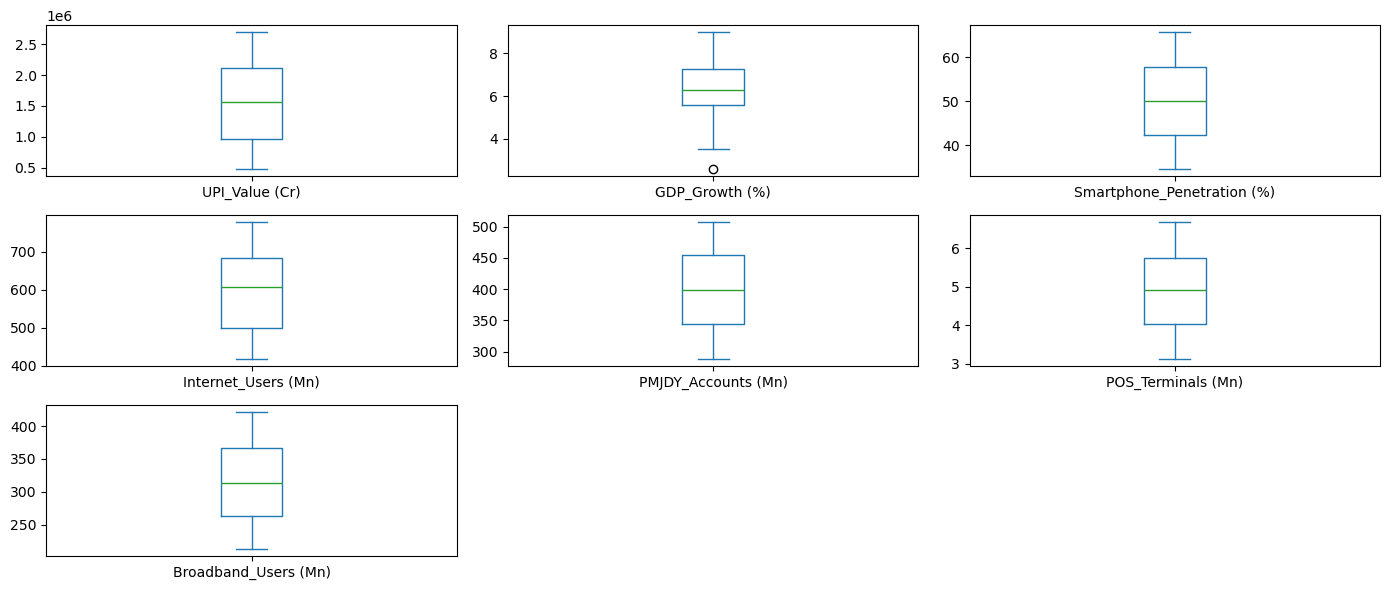

In [28]:
# Checking for outliers using Boxplot
df[['UPI_Value (Cr)', 'GDP_Growth (%)', 'Smartphone_Penetration (%)', 'Internet_Users (Mn)', 
           'PMJDY_Accounts (Mn)', 'POS_Terminals (Mn)', 'Broadband_Users (Mn)']].plot( kind='box', figsize=(14, 6),
    subplots=True, layout=(3, 3))

plt.tight_layout()
plt.show()


##### - So they have no outliers. 

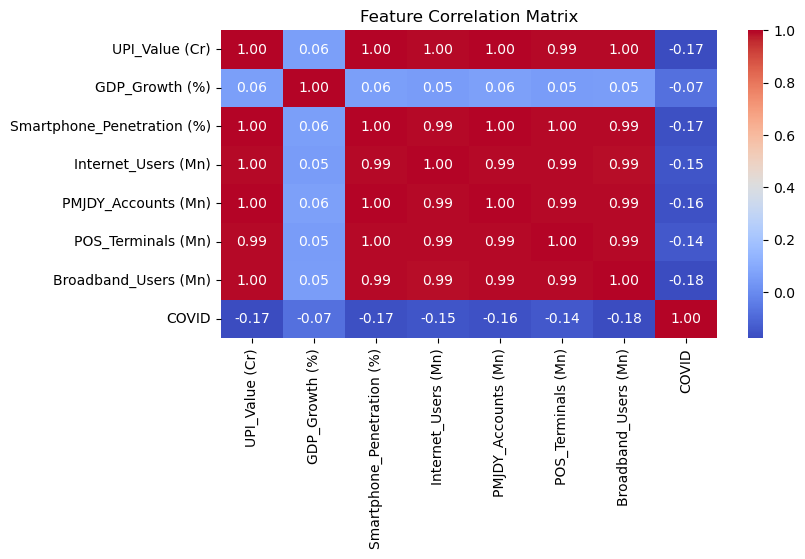

In [6]:
# Checking corrlation btw variables using Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

##### - Here severe multicollinearity exist btw the Independent Variables.

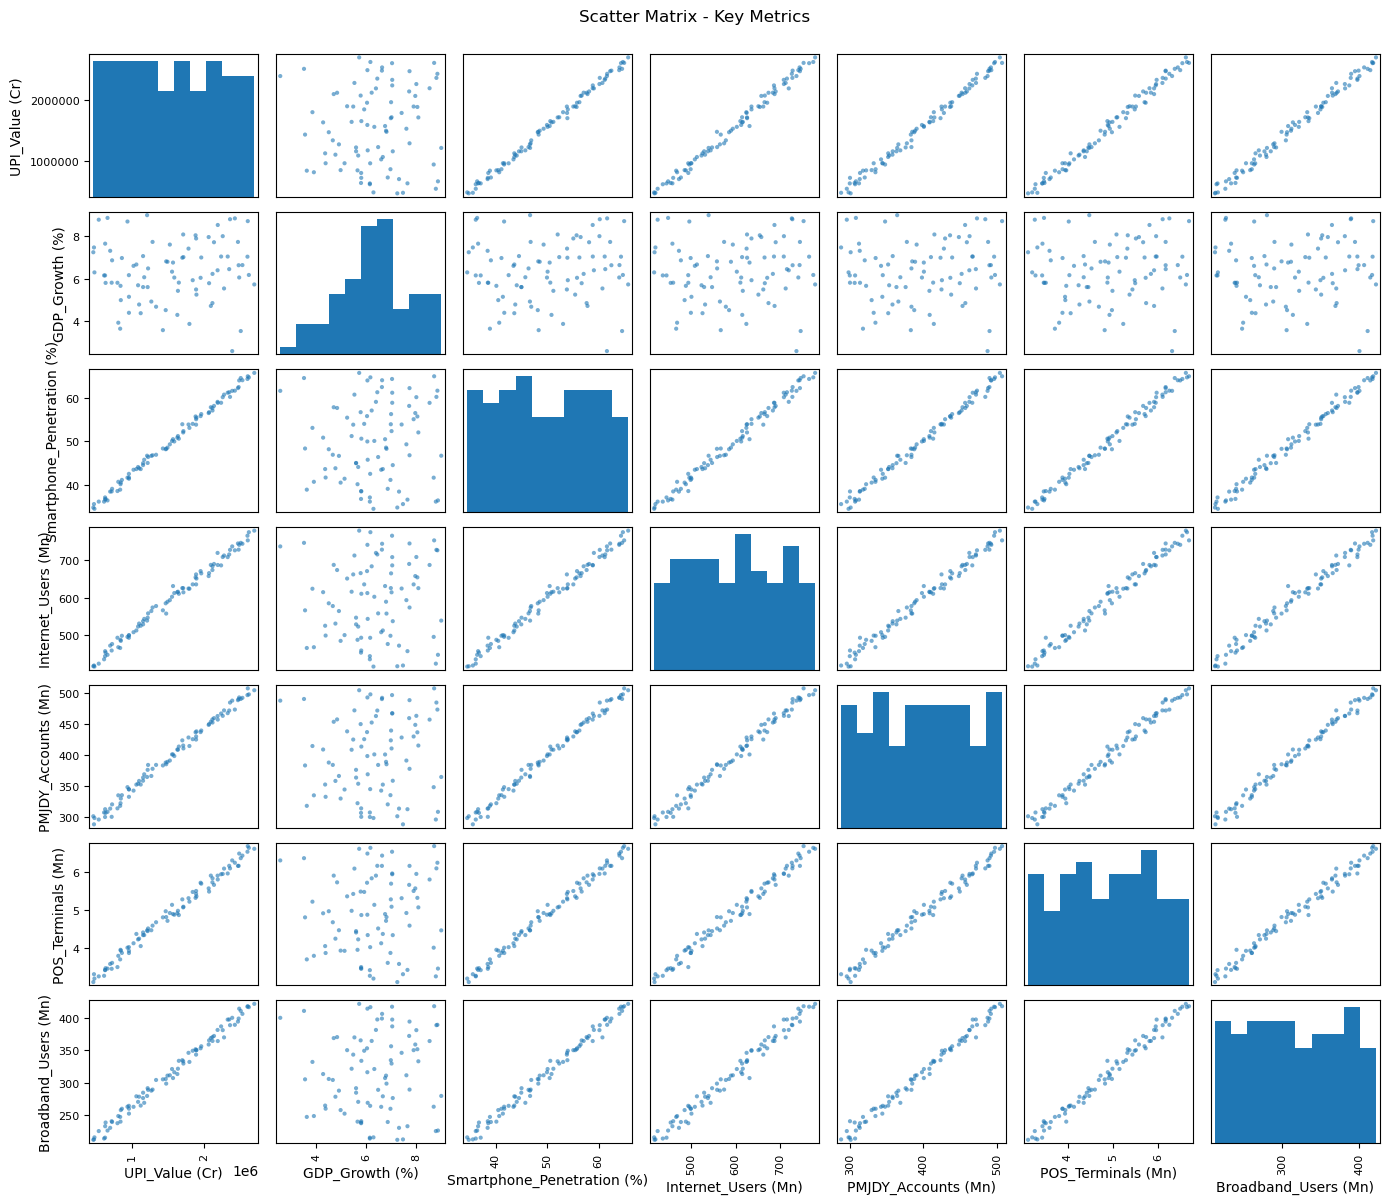

In [7]:
# Scatterplot of the dataset
from pandas.plotting import scatter_matrix

columns = ['UPI_Value (Cr)', 'GDP_Growth (%)', 'Smartphone_Penetration (%)', 'Internet_Users (Mn)', 
           'PMJDY_Accounts (Mn)', 'POS_Terminals (Mn)', 'Broadband_Users (Mn)' ]

scatter_matrix(df[columns], figsize=(14, 12), alpha=0.6, diagonal='hist')
plt.suptitle('Scatter Matrix - Key Metrics', y=1.0)
plt.tight_layout()
plt.show()

# Seaborn pairplot (better looking)
# sns.pairplot(df[columns], diag_kind='kde', corner=True)
# plt.show()

##### - Except GDP Growth every variables have a strong positive correlation

### Step 3 : Model Creation ( Linear Regression )

In [8]:
# Linear regression model building
x = df.iloc[:, 2: ]
y = df['UPI_Value (Cr)']

x = sm.add_constant(x)

x_train,x_test, y_train, y_test = train_test_split(x, y, random_state = 10, test_size = 0.2)

SLR_Model = sm.OLS(y_train, x_train).fit()
print(SLR_Model.summary())

                            OLS Regression Results                            
Dep. Variable:         UPI_Value (Cr)   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3630.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.99e-75
Time:                        11:50:12   Log-Likelihood:                -791.40
No. Observations:                  67   AIC:                             1599.
Df Residuals:                      59   BIC:                             1616.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### The model is significant as p-value < 0.05 [ Prob (F-statistic) ]. And model strength is too good, IVs can predict DV 99%. Also p-value > 0.05 [ Prob(JB) ], so the data is normally distributed. Even DW is 2.25 which is close to 2, so no autocorrelation is here. But Model have severe Multicollinearity [ Cond. No > 1000 ] etc.

#### Regularization [ Reducing Multicollinearity ]

In [69]:
# Step 1 : Scale the features

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

##### - Now x_train_scaled and x_test_scaled are standardized (mean=0, std=1), the reason we do Scaler.

In [70]:
# Step 2 : Fit regularized models, here using Elastic net

elastic_cv = ElasticNetCV(l1_ratio=[0.1,0.5,0.7,0.9,0.95,0.99], 
                            alphas=None, cv=5, random_state=10)
elastic_cv.fit(x_train_scaled, y_train)  # Just changing by this 2 lines with lasso or ridge, can fit those models

# Best alpha and l1_ratio
print("ElasticNet best alpha:", elastic_cv.alpha_)
print("ElasticNet best l1_ratio:", elastic_cv.l1_ratio_)

ElasticNet best alpha: 683.6386401691384
ElasticNet best l1_ratio: 0.99


In [71]:
# Identify ElasticNet-selected features
selected_features = (elastic_cv.coef_ != 0)  # Boolean mask for non-zero coefficients
x_train_selected = x_train_scaled[:, selected_features]  # Only selected features
x_test_selected = x_test_scaled[:, selected_features]    # Test data too

# Add constant for OLS
x_train_selected_const = sm.add_constant(x_train_selected)
x_test_selected_const = sm.add_constant(x_test_selected)

# Fit OLS
ols_selected = sm.OLS(y_train, x_train_selected_const).fit()
print(ols_selected.summary())

                            OLS Regression Results                            
Dep. Variable:         UPI_Value (Cr)   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3630.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.99e-75
Time:                        13:27:48   Log-Likelihood:                -791.40
No. Observations:                  67   AIC:                             1599.
Df Residuals:                      59   BIC:                             1616.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.587e+06   4248.259    373.603      0.0

##### Here I can see the multicollinearity reduced significantly. But the IVs are in another format.

In [72]:
# Step 4 : After scaling converting scaled arrays back to DataFrame with column names
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

# Selecting only features ElasticNet kept
x_train_selected_df = x_train_scaled_df.loc[:, selected_features] 

# Adding constant for OLS
x_train_selected_const = sm.add_constant(x_train_selected_df)

# Fitting OLS
ols_selected = sm.OLS(y_train, x_train_selected_const).fit()

print("="*80)
print("OLS MODEL SUMMARY (Scaled Data - WITH FEATURE NAMES)")
print("="*80)
print(ols_selected.summary())

OLS MODEL SUMMARY (Scaled Data - WITH FEATURE NAMES)
                            OLS Regression Results                            
Dep. Variable:         UPI_Value (Cr)   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3630.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.99e-75
Time:                        13:27:53   Log-Likelihood:                -791.40
No. Observations:                  67   AIC:                             1599.
Df Residuals:                      59   BIC:                             1616.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

### Extras

#### To find each Regularization technique and their alpha values - 

##### Note : This are not Scaled, to use this in model and fit this need to scaled these methods [ can be done by replacing "x_train" with "x_train_scaled" from above step 1 ].

In [14]:
# Finding the alpha value for Ridge regression (L2)
ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
ridge_cv.fit(x_train, y_train)

y_pred = ridge_cv.predict(x_test)

print("Best Alpha (Ridge):", ridge_cv.alpha_)
print("R² Score (Ridge):", ridge_cv.score(x_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Alpha (Ridge): 1.0
R² Score (Ridge): 0.9911492644880917
RMSE: 45809.15577705122


In [15]:
# Finding the alpha value for Lasso regression (L1)
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, random_state=10)
lasso_cv.fit(x_train, y_train)

y_pred = lasso_cv.predict(x_test)   # This line just for rmse score

print("Best Alpha (Lasso):", lasso_cv.alpha_)
print("R² Score (Lasso):", lasso_cv.score(x_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Alpha (Lasso): 10.0
R² Score (Lasso): 0.9912200382004424
RMSE: 45625.63479877721


In [61]:
# Finding the alpha value for Elastic Net regression ( L1 + L2 )
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10],
                          l1_ratio=[0.2, 0.5, 0.8],
                          cv=5, random_state=10)
elastic_cv.fit(x_train, y_train)

y_pred = elastic_cv.predict(x_test)

print("Best Alpha (ElasticNet):", elastic_cv.alpha_)
print("Best L1 Ratio (ElasticNet):", elastic_cv.l1_ratio_)
print("R² Score (ElasticNet):", elastic_cv.score(x_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Alpha (ElasticNet): 0.1
Best L1 Ratio (ElasticNet): 0.5
R² Score (ElasticNet): 0.9911595932588737
RMSE: 45782.41842898689


### Step 4 : Checking the assumptions

##### All assumptions other than Homoscedasticity are checked before, using the model i.e., Normality by JB p-value, Autocorrelation by DW value, and Multicollinearity by Condition No.

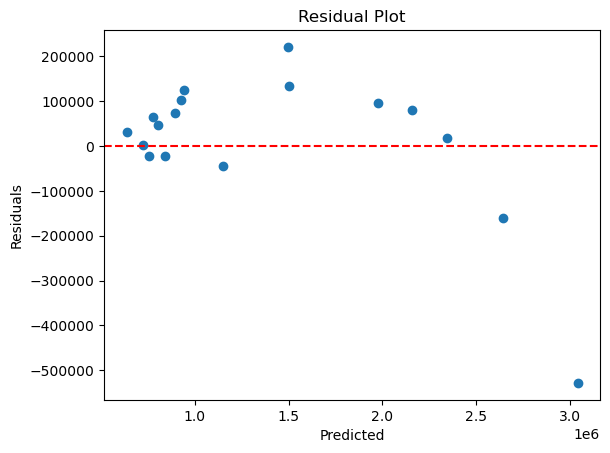

In [82]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### Using Log transformation for better Homoscedasticity

In [75]:
# Predict in log scale
y_train_pred_log = final_model.predict(x_train_selected_const)
y_test_pred_log = final_model.predict(x_test_selected_const)

# Convert back to original scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

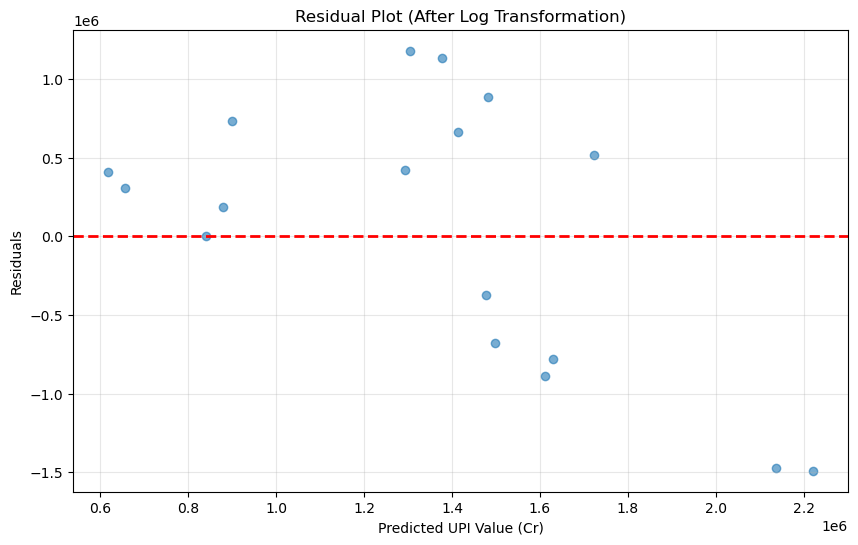

In [77]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted UPI Value (Cr)')
plt.ylabel('Residuals')
plt.title('Residual Plot (After Log Transformation)')
plt.grid(alpha=0.3)
plt.show()

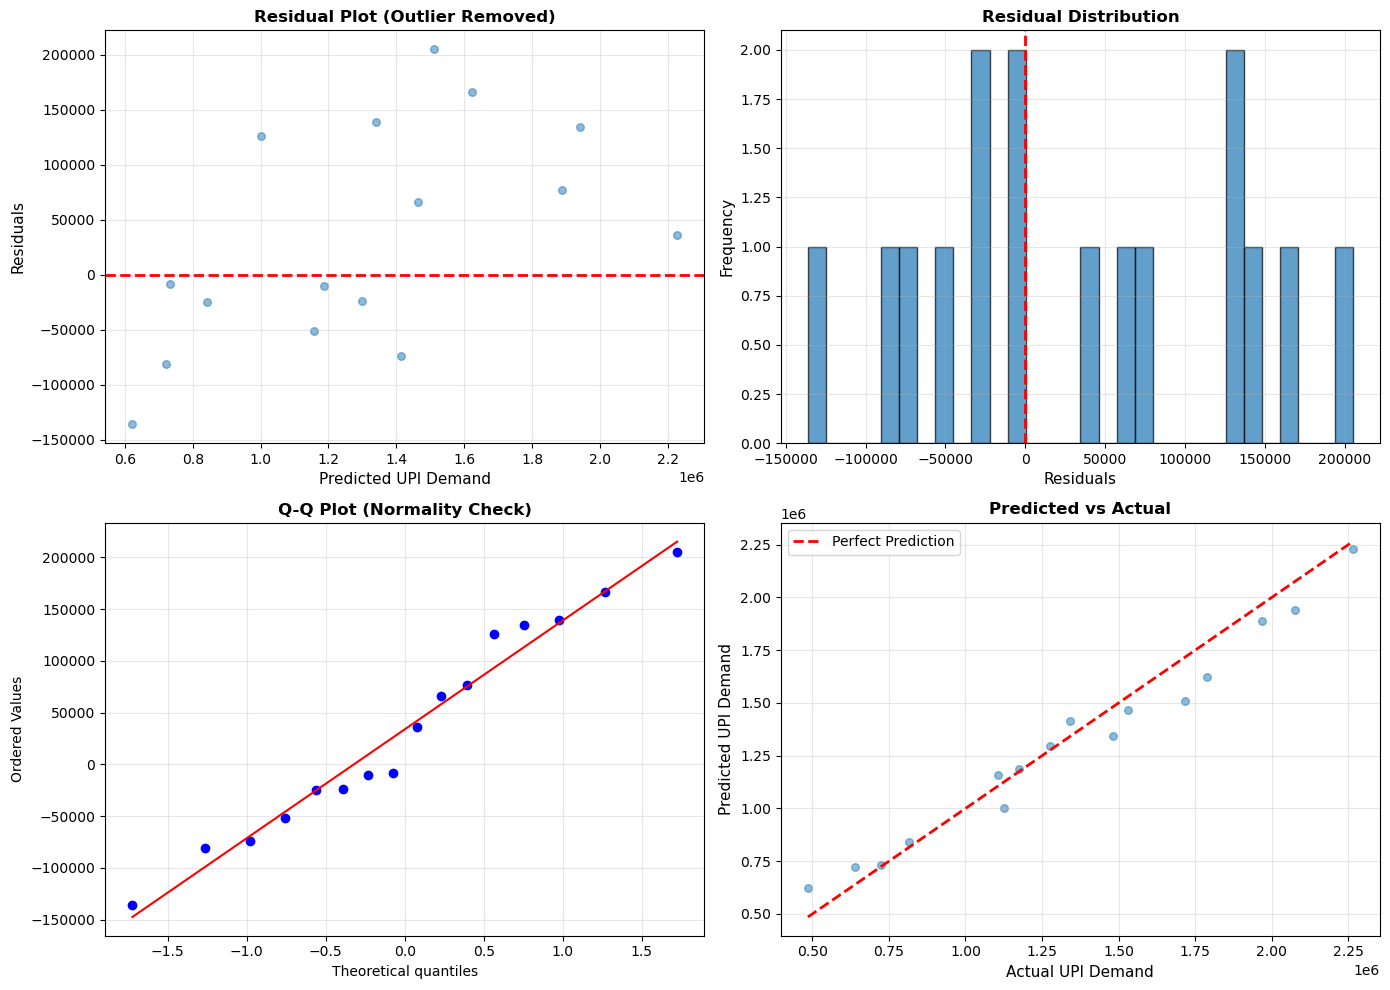

In [83]:
# To see all at once
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residual plot (clean)
axes[0, 0].scatter(y_pred_clean, residuals_clean, alpha=0.5, s=30)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted UPI Demand', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residual Plot (Outlier Removed)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Residual histogram
axes[0, 1].hist(residuals_clean, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q plot (normality check)
from scipy import stats
stats.probplot(residuals_clean, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Predicted vs Actual
axes[1, 1].scatter(y_test_clean, y_pred_clean, alpha=0.5, s=30)
axes[1, 1].plot([y_test_clean.min(), y_test_clean.max()], 
                [y_test_clean.min(), y_test_clean.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual UPI Demand', fontsize=11)
axes[1, 1].set_ylabel('Predicted UPI Demand', fontsize=11)
axes[1, 1].set_title('Predicted vs Actual', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_diagnostics_clean.png', dpi=300, bbox_inches='tight')
plt.show()


### Step 5 : To save the model for Prediction